In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Image Libraries
import cv2
import os

# For displaying images
from PIL import Image


Contents of input directory: ['sample_submission.csv', 'train_labels.csv', 'test', 'train']
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
Name: count, dtype: int64


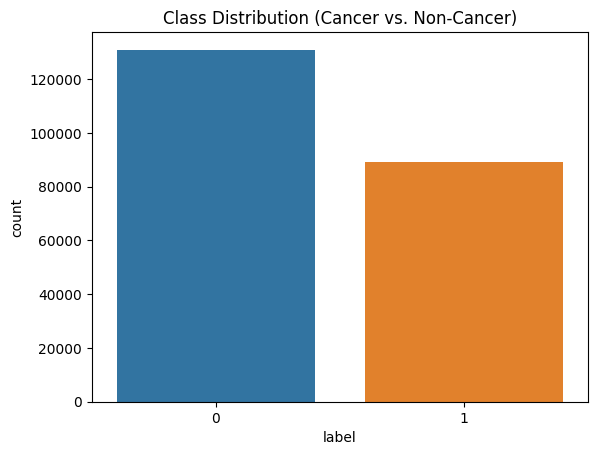

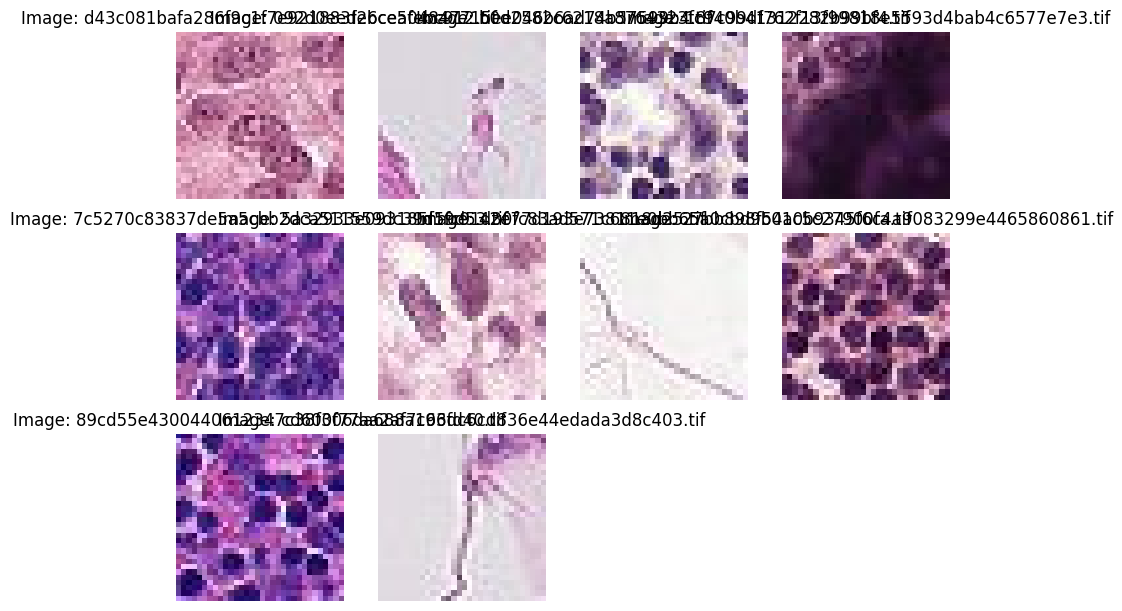

Example image filename: d43c081bafa286f9c1f7e921883f26ceafebc912.tif
Label for the example image: 1


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Step 1: Check the folder structure and contents
input_dir = "/kaggle/input/hcd-cropped"
print("Contents of input directory:", os.listdir(input_dir))

# Step 2: Load the train labels CSV
labels_path = os.path.join(input_dir, "train_labels.csv")
labels = pd.read_csv(labels_path)

# Display the first few rows of the labels CSV
print(labels.head())

# Step 3: Check the class distribution (tumor vs. no tumor)
print(labels['label'].value_counts())

# Plot class distribution
sns.countplot(x='label', data=labels)
plt.title('Class Distribution (Cancer vs. Non-Cancer)')
plt.show()

# Step 4: Display sample images from the train folder
train_dir = os.path.join(input_dir, "train")
image_files = os.listdir(train_dir)[:10]  # Load a few images for visualization

# Plot a few sample images
plt.figure(figsize=(10, 10))
for i, file in enumerate(image_files):
    image = Image.open(os.path.join(train_dir, file))
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Image: {file}")
    plt.axis('off')
plt.show()

# Step 5: Check if train_labels.csv correctly maps to the images in the train folder
print("Example image filename:", image_files[0])
example_image_id = image_files[0].replace(".tif", "")
print("Label for the example image:", labels[labels['id'] == example_image_id]['label'].values[0])



In [17]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision import transforms

# Defining the paths
data_dir = '/kaggle/input/hcd-cropped/train/'
labels_path = '/kaggle/input/hcd-cropped/train_labels.csv'

# Loading the labels
labels_df = pd.read_csv(labels_path)

# Setting a threshold for percentage of identical pixels 
threshold_percentage = 0.95

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Using Transform to convert PIL image to PyTorch tensor
transform = transforms.ToTensor()

# Class which loads images efficiently
class PCamDataset(Dataset):
    def __init__(self, labels_df, data_dir, transform=None):
        self.labels_df = labels_df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx]['id']
        img_path = os.path.join(self.data_dir, img_id + '.tif')
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img_id, img

# Function to check if the image has a majority of identical pixels without sampling
def is_noisy_image(image_tensor, threshold_percentage):
    img_flattened = image_tensor.view(-1, image_tensor.shape[-1])
    
    unique_pixels, counts = img_flattened.unique(dim=0, return_counts=True)
    
    # Find the percentage of the most common pixel
    max_pixel_percentage = counts.max().item() / counts.sum().item()
    
    return max_pixel_percentage >= threshold_percentage

# Initializing dataset and dataloader
dataset = PCamDataset(labels_df, data_dir, transform=transform)

# Adjust the batch size and num_workers to avoid the pin_memory issue
dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True, persistent_workers=False)

# List to store the IDs of non-noisy images
valid_image_ids = []

# Using the Progress bar to monitor the progress of the loop
total_images = len(labels_df)
with tqdm(total=total_images, desc="Processing Images") as pbar:
    for batch in dataloader:
        img_ids, imgs = batch
        for img_id, img in zip(img_ids, imgs):
            img_tensor = img.to(device)
            
            if not is_noisy_image(img_tensor, threshold_percentage):
                valid_image_ids.append(img_id)
        
        pbar.update(len(img_ids))

# Filtering out the labels of the valid images
clean_labels_df = labels_df[labels_df['id'].isin(valid_image_ids)]

# Saving the cleaned labels file
clean_labels_df.to_csv('clean_train_labels.csv', index=False)

print(f"Total valid images: {len(valid_image_ids)}")


Using device: cuda


Processing Images: 100%|██████████| 220025/220025 [12:34<00:00, 291.66it/s]


Total valid images: 219996


In [18]:
import shutil

# Move the file to a writable directory
shutil.move('clean_train_labels.csv', '/kaggle/working/clean_train_labels.csv')


'/kaggle/working/clean_train_labels.csv'

In [19]:
import matplotlib.pyplot as plt

# Function to display a noisy image inline using matplotlib
def display_noisy_image_inline(image_tensor, img_id):
    # Convert the tensor back to PIL image
    image_pil = transforms.ToPILImage()(image_tensor.cpu())
    
    # Display the image
    plt.imshow(image_pil)
    plt.title(f"Image ID: {img_id}")
    plt.axis('off')
    plt.show()

# Display the first 5 noisy images inline
for i in range(min(5, len(noisy_images))):
    img_id, img_tensor = noisy_images[i]
    display_noisy_image_inline(img_tensor, img_id)


In [9]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Custom Dataset class for handling PCam data
class PCamDataset(Dataset):
    def __init__(self, labels_df, data_dir, transform=None):
        self.labels_df = labels_df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx]['id']
        img_path = os.path.join(self.data_dir, img_id + '.tif')
        img = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['label']  # Assuming 'label' column exists in the DataFrame
        if self.transform:
            img = self.transform(img)
        return img, label

# Load clean labels DataFrame
clean_labels_df = pd.read_csv('/kaggle/input/clean-data/clean_train_labels.csv')

# Define the path to the image data
data_dir = '/kaggle/input/hcd-cropped/train/'  # Update this path as needed

# 70/10/20 Split: Split dataset into train, validation, and test sets
train_df, temp_df = train_test_split(clean_labels_df, test_size=0.30, stratify=clean_labels_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df['label'], random_state=42)

#print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

# Define transforms (without data augmentation as requested)
basic_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create datasets
train_dataset = PCamDataset(train_df, data_dir, transform=basic_transform)
val_dataset = PCamDataset(val_df, data_dir, transform=basic_transform)
test_dataset = PCamDataset(test_df, data_dir, transform=basic_transform)

# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print("DataLoaders created for train, validation, and test sets.")


DataLoaders created for train, validation, and test sets.


In [10]:
'''To provide a rough estimate, let’s assume that approximately 1 in 5 Americans develop skin cancer by age 70 (as stated by the Skin Cancer Foundation).This means that around 20% of the population will develop skin cancer at some point in their lifetime.'''

'To provide a rough estimate, let’s assume that approximately 1 in 5 Americans develop skin cancer by age 70 (as stated by the Skin Cancer Foundation).This means that around 20% of the population will develop skin cancer at some point in their lifetime.'

In [17]:
import torch
from tqdm import tqdm  # Import tqdm for progress bar

# Define label values
cancerous_label = 1  # Adjust this according to your dataset
non_cancerous_label = 0  # Adjust this according to your dataset

def check_distribution_and_shape(data_loader, cancerous_label):
    cancer_count = 0
    non_cancer_count = 0
    total_count = 0

    for _, labels in tqdm(data_loader, desc="Processing", unit="batch"):
        cancer_count += (labels == cancerous_label).sum().item()
        non_cancer_count += (labels == non_cancerous_label).sum().item()
        total_count += labels.size(0)

    return cancer_count, non_cancer_count, total_count

# Set num_workers to 0 for debugging
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check distribution for validation loader
val_cancer_count, val_non_cancer_count, val_total_count = check_distribution_and_shape(val_loader, cancerous_label)
print(f"Validation Loader Distribution - Cancerous: {val_cancer_count}, Non-Cancerous: {val_non_cancer_count}, Total: {val_total_count}")

# Check distribution for test loader
test_cancer_count, test_non_cancer_count, test_total_count = check_distribution_and_shape(test_loader, cancerous_label)
print(f"Test Loader Distribution - Cancerous: {test_cancer_count}, Non-Cancerous: {test_non_cancer_count}, Total: {test_total_count}")


Processing: 100%|██████████| 691/691 [04:18<00:00,  2.67batch/s]


Validation Loader Distribution - Cancerous: 17912, Non-Cancerous: 26307, Total: 44219


Processing: 100%|██████████| 341/341 [02:15<00:00,  2.52batch/s]

Test Loader Distribution - Cancerous: 8823, Non-Cancerous: 12957, Total: 21780


In [25]:
import torch
from torch.utils.data import DataLoader, Subset
import random
from tqdm import tqdm  # Import tqdm for progress bar

# Function to create a balanced data loader with 20% cancerous and 80% non-cancerous samples
def create_balanced_loader_with_progress(data_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2):
    cancerous_indices = []
    non_cancerous_indices = []
    
    # Use tqdm for the progress bar while iterating over the dataset
    print("Separating cancerous and non-cancerous samples...")
    for idx, (images, labels) in tqdm(enumerate(data_loader.dataset), total=len(data_loader.dataset), desc="Processing"):
        if labels == cancerous_label:
            cancerous_indices.append(idx)
        else:
            non_cancerous_indices.append(idx)
    
    # Shuffle the indices
    random.shuffle(cancerous_indices)
    random.shuffle(non_cancerous_indices)
    
    # Determine number of samples for the new loader
    num_cancerous = int(len(cancerous_indices) * cancerous_ratio)
    num_non_cancerous = int(len(non_cancerous_indices) * (1 - cancerous_ratio))
    
    # Select the required amount of cancerous and non-cancerous samples
    selected_cancerous_indices = cancerous_indices[:num_cancerous]
    selected_non_cancerous_indices = non_cancerous_indices[:num_non_cancerous]
    
    # Combine the selected indices
    new_indices = selected_cancerous_indices + selected_non_cancerous_indices
    random.shuffle(new_indices)
    
    # Create the new dataset and data loader
    new_subset = Subset(data_loader.dataset, new_indices)
    new_loader = DataLoader(new_subset, batch_size=data_loader.batch_size, shuffle=True)
    
    return new_loader

# Function to check the distribution of cancerous and non-cancerous samples in a data loader
def check_distribution_with_progress(data_loader, cancerous_label):
    cancer_count = 0
    non_cancer_count = 0
    total_count = 0
    
    print("Checking distribution in the new data loader...")
    
    # Use tqdm for the progress bar
    for images, labels in tqdm(data_loader, desc="Checking"):
        cancer_count += (labels == cancerous_label).sum().item()
        non_cancer_count += (labels != cancerous_label).sum().item()
        total_count += len(labels)
    
    return cancer_count, non_cancer_count, total_count

# Define your cancerous and non-cancerous labels
cancerous_label = 1
non_cancerous_label = 0

# Create the new test data loader with 20% cancerous and 80% non-cancerous images
new_test_loader = create_balanced_loader_with_progress(test_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2)

# Check the distribution of the new test loader
test_cancer_count, test_non_cancer_count, test_total_count = check_distribution_with_progress(new_test_loader, cancerous_label)

# Print the distribution
print(f"New Test Loader Distribution:")
print(f"Cancerous: {test_cancer_count}, Non-Cancerous: {test_non_cancer_count}, Total: {test_total_count}")


Separating cancerous and non-cancerous samples...


Processing: 100%|██████████| 21780/21780 [00:35<00:00, 606.09it/s]


Checking distribution in the new data loader...


Checking: 100%|██████████| 190/190 [00:20<00:00,  9.31it/s]

New Test Loader Distribution:
Cancerous: 1764, Non-Cancerous: 10365, Total: 12129


In [26]:
import torch
from torch.utils.data import DataLoader, Subset
import random
from tqdm import tqdm  # Import tqdm for progress bar

# Function to create a balanced data loader with 20% cancerous and 80% non-cancerous samples
def create_balanced_loader_with_progress(data_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2):
    cancerous_indices = []
    non_cancerous_indices = []
    
    # Use tqdm for the progress bar while iterating over the dataset
    print("Separating cancerous and non-cancerous samples...")
    for idx, (images, labels) in tqdm(enumerate(data_loader.dataset), total=len(data_loader.dataset), desc="Processing"):
        if labels == cancerous_label:
            cancerous_indices.append(idx)
        else:
            non_cancerous_indices.append(idx)
    
    # Shuffle the indices
    random.shuffle(cancerous_indices)
    random.shuffle(non_cancerous_indices)
    
    # Determine number of samples for the new loader
    num_cancerous = int(len(cancerous_indices) * cancerous_ratio)
    num_non_cancerous = int(len(non_cancerous_indices) * (1 - cancerous_ratio))
    
    # Select the required amount of cancerous and non-cancerous samples
    selected_cancerous_indices = cancerous_indices[:num_cancerous]
    selected_non_cancerous_indices = non_cancerous_indices[:num_non_cancerous]
    
    # Combine the selected indices
    new_indices = selected_cancerous_indices + selected_non_cancerous_indices
    random.shuffle(new_indices)
    
    # Create the new dataset and data loader
    new_subset = Subset(data_loader.dataset, new_indices)
    new_loader = DataLoader(new_subset, batch_size=data_loader.batch_size, shuffle=True)
    
    return new_loader

# Function to check the distribution of cancerous and non-cancerous samples in a data loader
def check_distribution_with_progress(data_loader, cancerous_label):
    cancer_count = 0
    non_cancer_count = 0
    total_count = 0
    
    print("Checking distribution in the new data loader...")
    
    # Use tqdm for the progress bar
    for images, labels in tqdm(data_loader, desc="Checking"):
        cancer_count += (labels == cancerous_label).sum().item()
        non_cancer_count += (labels != cancerous_label).sum().item()
        total_count += len(labels)
    
    return cancer_count, non_cancer_count, total_count

# Define your cancerous and non-cancerous labels
cancerous_label = 1
non_cancerous_label = 0

# --- For Validation Loader ---
# Create the new validation data loader with 20% cancerous and 80% non-cancerous images
new_val_loader = create_balanced_loader_with_progress(val_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2)

# Check the distribution of the new validation loader
val_cancer_count, val_non_cancer_count, val_total_count = check_distribution_with_progress(new_val_loader, cancerous_label)

# Print the distribution for validation loader
print(f"New Validation Loader Distribution:")
print(f"Cancerous: {val_cancer_count}, Non-Cancerous: {val_non_cancer_count}, Total: {val_total_count}")


# --- For Test Loader ---
# Create the new test data loader with 20% cancerous and 80% non-cancerous images
new_test_loader = create_balanced_loader_with_progress(test_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2)

# Check the distribution of the new test loader
test_cancer_count, test_non_cancer_count, test_total_count = check_distribution_with_progress(new_test_loader, cancerous_label)

# Print the distribution for test loader
print(f"New Test Loader Distribution:")
print(f"Cancerous: {test_cancer_count}, Non-Cancerous: {test_non_cancer_count}, Total: {test_total_count}")


Separating cancerous and non-cancerous samples...


Processing: 100%|██████████| 44219/44219 [01:51<00:00, 395.46it/s]


Checking distribution in the new data loader...


Checking: 100%|██████████| 385/385 [00:41<00:00,  9.34it/s]


New Validation Loader Distribution:
Cancerous: 3582, Non-Cancerous: 21045, Total: 24627
Separating cancerous and non-cancerous samples...


Processing: 100%|██████████| 21780/21780 [00:35<00:00, 607.07it/s]


Checking distribution in the new data loader...


Checking: 100%|██████████| 190/190 [00:19<00:00,  9.59it/s]

New Test Loader Distribution:
Cancerous: 1764, Non-Cancerous: 10365, Total: 12129
